In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [10]:
PATH = '~/IDAO2020/'
data = pd.read_csv(PATH+'train.csv', index_col= 'id')
data_test = pd.read_csv(PATH+'Track 1/'+'test.csv', index_col= 'id')
data.head(3)

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


In [3]:
data.shape

(649912, 14)

In [11]:
data_test.shape

(284071, 8)

In [14]:
#data_test['sat_id'].unique()

In [7]:
data['sat_id'].nunique()

600

In [20]:
type(data['epoch'][0])

str

In [23]:
data['epoch'] = pd.to_datetime(data['epoch'])
#data.dtypes

## Smape

In [144]:
def smape(sat_pred_vals, sat_true_vals): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((sat_pred_vals - sat_true_vals) 
        / (np.abs(sat_pred_vals) + np.abs(sat_true_vals)))) 

## Lagging, missed orbit

In [56]:
#from TK
m_id = 0
n_points = 50

def plot_orbits(m_id,n_points):
    m_data = data[data.sat_id == m_id]


    r = np.sqrt(m_data.x**2+m_data.y**2+m_data.z**2)
    r_sim = np.sqrt(m_data.x_sim**2+m_data.y_sim**2+m_data.z_sim**2)
    speed = np.sqrt(m_data.Vx**2+m_data.Vy**2+m_data.Vz**2)
    speed_sim = np.sqrt(m_data.Vx_sim**2+m_data.Vy_sim**2+m_data.Vz_sim**2)

    f, (ax1,ax2,ax3, ax4) = plt.subplots(1,4,figsize = (15,5))

    ax1.scatter(m_data[-n_points:].z,m_data[-n_points:].x, label = 'end real')
    ax1.scatter(m_data[-n_points:].z_sim,m_data[-n_points:].x_sim, label = 'end sim')
    ax1.plot(m_data[:n_points].z,m_data[:n_points].x, label = 'start real')
    ax1.plot(m_data[:n_points].z_sim,m_data[:n_points].x_sim, label = 'start sim')
    ax1.set_title('x-z plane')


    ax2.scatter(m_data[-n_points:].z,m_data[-n_points:].y, label = 'end real')
    ax2.scatter(m_data[-n_points:].z_sim,m_data[-n_points:].y_sim, label = 'end sim')
    ax2.plot(m_data[:n_points].z,m_data[:n_points].y, label = 'start real')
    ax2.plot(m_data[:n_points].z_sim,m_data[:n_points].y_sim, label = 'start sim')
    ax2.set_title('z-y plane')

    ax3.scatter(m_data[-n_points:].y,m_data[-n_points:].x, label = 'end real')
    ax3.scatter(m_data[-n_points:].y_sim,m_data[-n_points:].x_sim, label = 'end sim')
    ax3.plot(m_data[:n_points].y,m_data[:n_points].x, label = 'start real')
    ax3.plot(m_data[:n_points].y_sim,m_data[:n_points].x_sim, label = 'start sim')
    ax3.legend()
    ax3.set_title('y-x plane')

    ax4.plot((r-r_sim)/r, label = 'position')
    ax4.plot((speed-speed_sim)/speed, label='speed')
    ax4.legend()
    ax4.set_title('relative r error')


    plt.tight_layout()

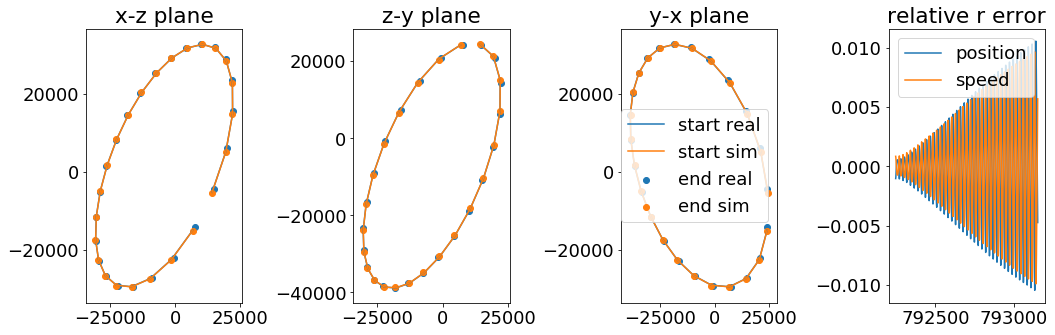

In [119]:
plot_orbits(388,24)

It looks like the first 25 measurements define a complete orbit for all satellites (still need to confirm).

## Metadata for each satellite

In [62]:
sat_data = pd.DataFrame(index = data['sat_id'].unique())

In [65]:
sat_data['number_observations'] = data['sat_id'].value_counts()

In [94]:
dim = 'x'
by_id = data.groupby('sat_id')
data.groupby('sat_id')['V{}'.format(dim)].max() - \
    data.groupby('sat_id')['V{}'.format(dim)].min()

sat_id
0       2.765835
1      10.635625
2       5.376717
3       6.104521
4       7.558007
         ...    
595     2.275725
596     5.976143
597     5.347778
598     5.553668
599     8.295579
Name: Vx, Length: 600, dtype: float64

In [95]:
by_id = data.groupby('sat_id')
for dim in ['x','y','z']:
    sat_data['{}_max_position_change'.format(dim)] = by_id['{}'.format(dim)].max() - \
        by_id['{}'.format(dim)].min()
    sat_data['{}_max_vel_change'.format(dim)] = by_id['V{}'.format(dim)].max() - \
        by_id['V{}'.format(dim)].min()
    sat_data['{}_max__position_sim_change'.format(dim)] = by_id['{}_sim'.format(dim)].max() - \
        by_id['{}_sim'.format(dim)].min()
    sat_data['{}_max_vel_sim_change'.format(dim)] = by_id['V{}_sim'.format(dim)].max() - \
        by_id['V{}_sim'.format(dim)].min()

In [130]:
sat_data['orbit_length']=(by_id['epoch'].nth(24) - by_id['epoch'].nth(0))/np.timedelta64(1, 's')
#should be perfectly correlated with number_observations

In [132]:
sat_data.sort_values(by=['orbit_length'],inplace=True)

In [170]:
#plot_orbits(524,24)

In [138]:
sat_data.tail()

,number_observations,x_max_position_change,x_max_vel_change,x_max__position_sim_change,x_max_vel_sim_change,y_max_position_change,y_max_vel_change,y_max__position_sim_change,y_max_vel_sim_change,z_max_position_change,z_max_vel_change,z_max__position_sim_change,z_max_vel_sim_change,orbit_length
524,121,204057.388319,3.902111,203307.854811,3.839979,204864.465019,3.811358,207177.850910,3.734266,211452.070973,3.312034,212446.375202,3.305617,548895.300
515,111,349884.533268,4.458237,291245.701907,4.635837,228674.614734,3.677797,139953.217260,3.011791,210325.573632,4.275259,159156.822325,3.719702,581819.968
487,110,194067.965767,3.601092,192657.438915,3.324753,275223.319912,4.758166,281154.239808,4.583399,166400.231168,3.121412,164466.822890,2.790221,607574.986
301,99,293299.335700,3.944686,285183.546140,4.110525,165222.353203,3.072113,141567.488031,3.028195,244164.138327,3.541806,231702.285982,3.844121,654711.402
252,94,96648.320588,2.040128,97822.243017,1.901533,332258.430854,4.928255,326241.750269,4.616125,221375.639006,4.670957,225414.544092,4.313328,688346.439


In [133]:
sat_data.head()

,number_observations,x_max_position_change,x_max_vel_change,x_max__position_sim_change,x_max_vel_sim_change,y_max_position_change,y_max_vel_change,y_max__position_sim_change,y_max_vel_sim_change,z_max_position_change,z_max_vel_change,z_max__position_sim_change,z_max_vel_sim_change,orbit_length
372,6320,20166.852634,12.604810,19725.920108,12.559115,20367.175708,12.915528,20673.577596,12.622835,7484.678219,5.080342,7569.525856,4.852040,10172.850
186,6204,17278.520514,10.657485,17280.150487,10.659816,18599.207193,11.549276,18587.446307,11.548845,18364.682069,11.396827,18366.070463,11.394058,10363.663
429,6074,13341.089555,8.333994,13324.935757,8.324916,18809.770303,12.574596,19466.875073,12.173668,20760.098424,12.527239,19671.147604,12.225302,10587.445
321,5673,22537.200496,13.113400,22565.448234,13.098392,21497.008187,12.590841,21513.176304,12.579674,8459.611826,4.781254,8450.877770,4.766318,11331.959
529,5665,20481.311707,11.332751,20484.831164,11.329887,11496.779574,6.360180,11527.445323,6.373242,21382.136364,11.846191,21420.190163,11.835567,11351.047


In [159]:
true_cols = ['x','y','z','Vx','Vy','Vz']
sim_cols = [i+'_sim' for i in true_cols]
by_id_true = by_id[true_cols]
by_id_sim = by_id[sim_cols]
smape(np.array(by_id_true.nth(2)),np.array(by_id_sim.nth(2)))
#add smape for each satellite to sat_data
#by_id.nth(0)
#sat_data['smape'] = 

0.011811728659823127

In [165]:
def smape_train(df):#,true_cols,sim_cols): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((np.array(df[sim_cols]) - np.array(df[true_cols])) 
        / (np.abs(np.array(df[sim_cols])) + np.abs(np.array(df[true_cols]))))) 

In [167]:
sat_data['smape'] = by_id.apply(smape_train)

In [168]:
sat_data.sort_values(by=['smape'],inplace=True)

In [175]:
sat_data.head(3)

,number_observations,x_max_position_change,x_max_vel_change,x_max__position_sim_change,x_max_vel_sim_change,y_max_position_change,y_max_vel_change,y_max__position_sim_change,y_max_vel_sim_change,z_max_position_change,z_max_vel_change,z_max__position_sim_change,z_max_vel_sim_change,orbit_length,smape
286,786,55883.559856,4.328172,55906.645288,4.330390,65659.405615,5.107088,65635.177505,5.105461,75393.008488,5.875420,75396.642061,5.874925,81812.343,0.001417
147,728,70287.838965,5.027765,70262.105292,5.023632,58411.738787,4.177229,58397.963779,4.173199,79157.261600,5.624858,79028.462617,5.624751,88306.610,0.003045
67,786,69727.891405,5.376871,69758.945509,5.380224,80773.882169,6.221468,80770.291994,6.221306,42514.247636,3.286186,42474.878006,3.283061,81865.779,0.004227


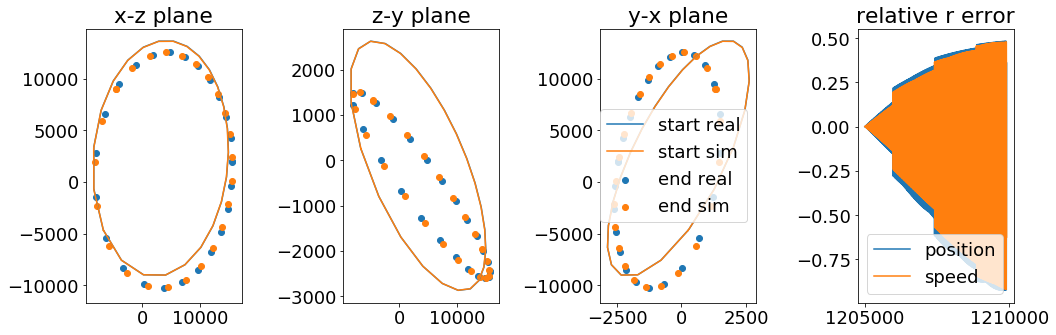

In [189]:
plot_orbits(588,25)

In [176]:
sat_data.tail(3)

,number_observations,x_max_position_change,x_max_vel_change,x_max__position_sim_change,x_max_vel_sim_change,y_max_position_change,y_max_vel_change,y_max__position_sim_change,y_max_vel_sim_change,z_max_position_change,z_max_vel_change,z_max__position_sim_change,z_max_vel_sim_change,orbit_length,smape
372,6320,20166.852634,12.604810,19725.920108,12.559115,20367.175708,12.915528,20673.577596,12.622835,7484.678219,5.080342,7569.525856,4.852040,10172.850,0.576317
588,4894,23954.955609,12.344008,23861.775447,12.224229,5494.347373,2.926696,5488.632987,2.926428,24011.747619,12.531168,23818.056494,12.525387,13145.348,0.599493
429,6074,13341.089555,8.333994,13324.935757,8.324916,18809.770303,12.574596,19466.875073,12.173668,20760.098424,12.527239,19671.147604,12.225302,10587.445,0.681448


In [179]:
sat_data.shape

(600, 15)

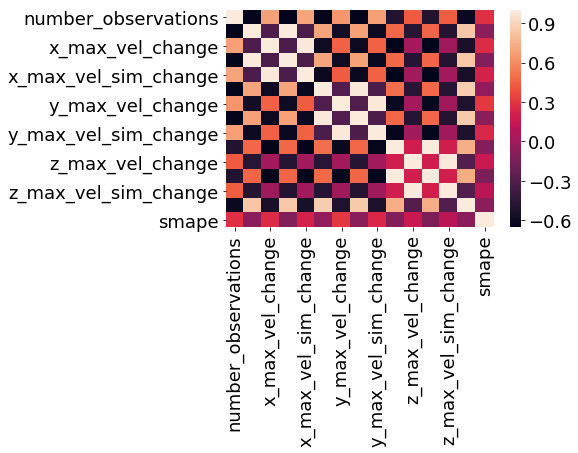

In [188]:
#heat map of correlations
import seaborn as sns
corr = sat_data.corr()
sns.heatmap(corr, annot=False);

In [190]:
sat_data.to_csv('sat_data.csv', encoding='utf-8')

In [184]:
sat_data.columns

Index(['number_observations', 'x_max_position_change', 'x_max_vel_change',
       'x_max__position_sim_change', 'x_max_vel_sim_change',
       'y_max_position_change', 'y_max_vel_change',
       'y_max__position_sim_change', 'y_max_vel_sim_change',
       'z_max_position_change', 'z_max_vel_change',
       'z_max__position_sim_change', 'z_max_vel_sim_change', 'orbit_length',
       'smape'],
      dtype='object')

## Relative error at end of simulation vs. orbit length

First find the orbit length for each satellite.

In [61]:
data_0 = data[data['sat_id']==0]
data_0.columns

Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim',
       'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'],
      dtype='object')

In [64]:
sat_data.shape

(600, 0)